# Intensity Interferometry

Consider a pair of detectors, $a$ and $b$, measuring the intensity of a common (extended) source of light. The time correlation of both signals provides information on the spatial distribution of the source.

$$\left<I_a(t)I_b(t)\right>_{\tau}=\frac{1}{\tau}\int_t^{t+\tau}\mathrm{d}t'I_a(t')I_b(t'),$$

where $\tau$ is the integration time of the correlator.

Denoting $\mathbf{r}$ the baseline--the relative distance between a pair of detectors--the intensity correlation can be written:

$$\left<I_a(t)I_b(t)\right>_{\tau}(\mathbf{r}) = \left<I_a\right>\left<I_b\right>(1+\left|\gamma_{12}(\mathbf{r})\right|^2),$$

where $\gamma_{12}(\textbf{r})$ is directly related to the Fourier transform of the source density distribution.

Here, we investigate the signal measured observed for an elliptic source, using a pair of telescope with an arbitrary baseline.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib
import II
from II import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

In [4]:
ls = II.LightSource(shape='ellipse')
uv = II.UVplane(ls)

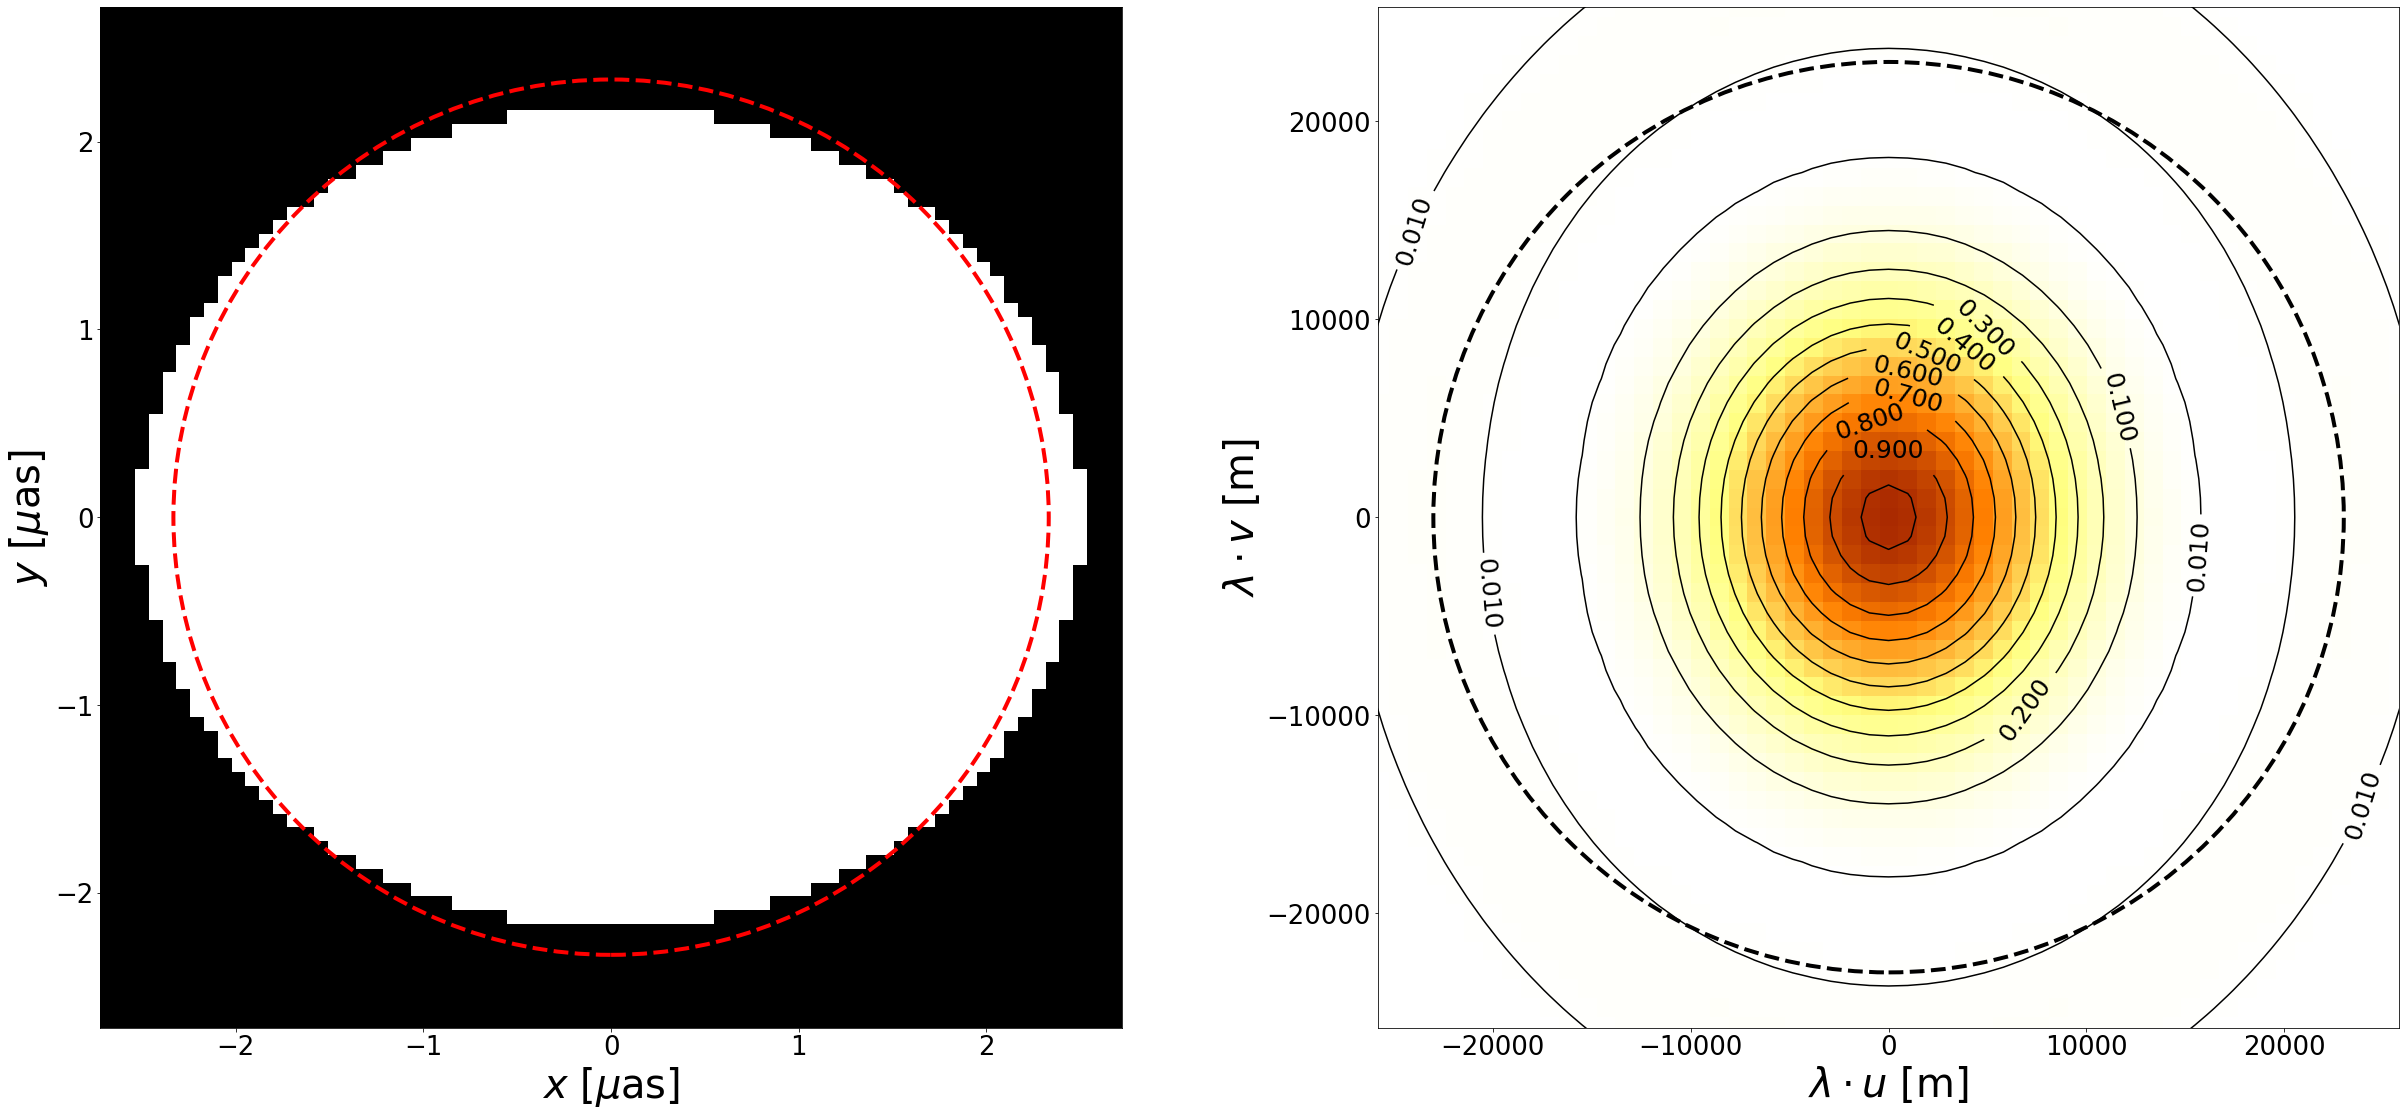

In [5]:
uv.plotSource()

In [16]:
cta = II.TelescopeArray(uv,layout='layouts/basic_cta', nGrid=64, nPerTraj=128)

0 0 layouts/basic_cta/23m_telescope.csv layouts/basic_cta/23m_telescope.csv
0 1 layouts/basic_cta/12m_telescope.csv layouts/basic_cta/23m_telescope.csv
1 1 layouts/basic_cta/12m_telescope.csv layouts/basic_cta/12m_telescope.csv
0 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/23m_telescope.csv
1 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/12m_telescope.csv
2 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/04m_telescope.csv


In [17]:
cta.setGrids()

Computing SNR grid:


Pairs (4.0-4.0): 100%|██████████| 2379/2379 [00:34<00:00, 68.30it/s]
/net/cephfs/home/hlasco/intensity_interferrometry_layout_benchmark/II.py:366: RuntimeWarning: invalid value encountered in true_divide
  areaGrid = np.where(nInGrid == 0, 0, areaGrid / nInGrid)


In [18]:
snr  = cta.getSNRGrid()
time = cta.getTimeGrid()
area = cta.getAreaGrid()

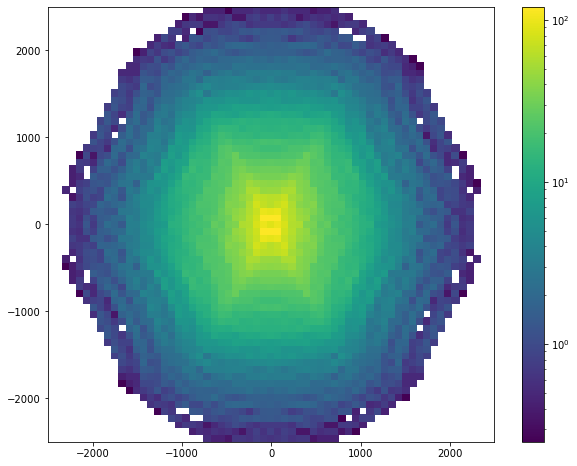

In [19]:
x = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
y = np.linspace(-cta.bline_max, cta.bline_max, cta.N_snr_grid)
xx, yy = np.meshgrid(x, y)
plt.figure(figsize=(10, 8))
plt.pcolormesh(xx ,yy , snr.T, norm=LogNorm())
plt.colorbar()

<ipython-input-28-623c5a87c991>:6: RuntimeWarning: invalid value encountered in true_divide
  sigma = np.fabs(signal2 / (snr * np.sqrt(nNights)))


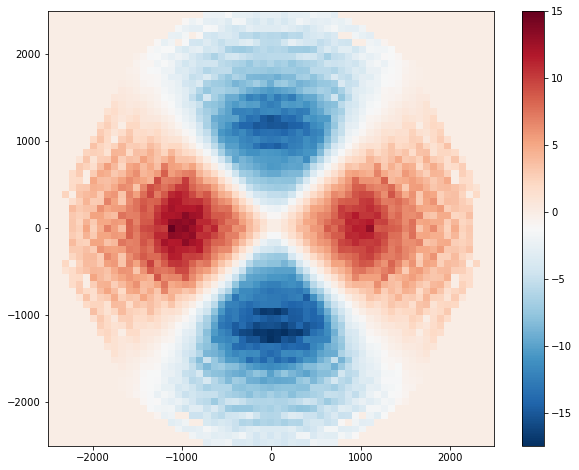

In [28]:
nNights = 100000
signal1, _ = cta.getSignal(nNights = nNights, phi_source = np.pi/2, bNoise=False)
signal2, std = cta.getSignal(nNights = nNights, phi_source = 0, bNoise=True)

s = (signal1 - signal2)
sigma = np.fabs(signal2 / (snr * np.sqrt(nNights)))
data = s/sigma
mask = (snr<1e-4)
data[mask] = 0

plt.figure(figsize=(10, 8))
plt.pcolormesh(xx ,yy ,(data.T), cmap='RdBu_r')#, vmin=-100, vmax=100)
plt.colorbar()

In [59]:
import emcee

def log_likelihood(phi, signal, snr, i_night, sts):
    model, _ = cta.getSignal(nNights = i_night, phi_source = phi, bNoise=False)
    #mask = (snr * np.sqrt(i_night) > 1e-10 )
    mask = (std > 0 )
    
    #print(model.shape, mask.shape)
    
    #std = model[mask] / (snr[mask] * np.sqrt(i_night))
    obs = signal[mask]
    exp = model[mask]
    std_ = std[mask]
    
    ret =  -.5*np.sum((obs - exp)**2 / std_**2)# + np.log(2*np.pi*std**2)
    #print(phi, ret)
    return ret

def log_prior(phi): #prior for rp is flat around rp_true with + and - 20x error on rp_true
    phi_range = -np.pi/4 < phi < np.pi/4
    if phi_range:
        return 0.0
    return -np.inf

def log_probability(phi, signal, snr, i_night, std):
    lp = log_prior(phi)
    return lp + log_likelihood(phi, signal, snr, i_night, std)

def run_mcmc(i_night, phi_source, n_walkers=4, steps=1000):
    pos = np.array([[np.random.uniform(-np.pi/4, np.pi/4)] for k in range(n_walkers)])
    nwalkers, ndim = pos.shape
    signal, _ = cta.getSignal(nNights = i_night, phi_source = phi_source, bNoise=True)
    snr = cta.getSNRGrid()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(signal, snr, i_night, std))
    sampler.run_mcmc(pos, steps, progress=True)

    return sampler

In [67]:
phi_source=0.0
steps = 1000
sampler_1 = run_mcmc(i_night=1, phi_source = 0.0, n_walkers=2, steps=steps)
sampler_10 = run_mcmc(i_night=10, phi_source = 0.0, n_walkers=2, steps=steps)
sampler_100 = run_mcmc(i_night=100, phi_source = 0.0, n_walkers=2, steps=steps)
sampler_1000 = run_mcmc(i_night=1000, phi_source = 0.0, n_walkers=2, steps=steps)

labels = ["phi_source"]
truths = [phi_source]

 
flat_samples_1 = sampler_1.get_chain(discard=steps//10, thin=1, flat=True)
flat_samples_10 = sampler_10.get_chain(discard=steps//10, thin=1, flat=True)
flat_samples_100 = sampler_100.get_chain(discard=steps//10, thin=1, flat=True)
flat_samples_1000 = sampler_1000.get_chain(discard=steps//10, thin=1, flat=True)


100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


In [68]:
print("MCMC results:")
mcmc = np.percentile(flat_samples_1[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('1 night:', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1]*180/np.pi, q[0]*180/np.pi, q[1]*180/np.pi))

mcmc = np.percentile(flat_samples_10[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('10 nights:', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1]*180/np.pi, q[0]*180/np.pi, q[1]*180/np.pi))

mcmc = np.percentile(flat_samples_100[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('100 nights:', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1]*180/np.pi, q[0]*180/np.pi, q[1]*180/np.pi))

mcmc = np.percentile(flat_samples_1000[:], [16, 50, 84]) #takes 16%, 50% and 84% (mu-MinusError, mu and mu+PlusError)
q = np.diff(mcmc) #calculates MinusError and PlusError
print('1000 nights:', labels[0],"={0:.5f} -{1:.5f} +{2:.5f}".format(mcmc[1]*180/np.pi, q[0]*180/np.pi, q[1]*180/np.pi))

MCMC results:
1 night: phi_source =-7.74289 -26.54019 +33.69661
10 nights: phi_source =1.74202 -6.08750 +5.13603
100 nights: phi_source =0.51137 -0.58272 +0.43606
1000 nights: phi_source =0.04904 -0.04792 +0.04847


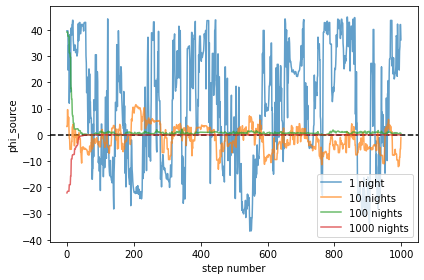

In [85]:
plt.axhline(truths[0], color='k', linestyle='--')
plt.plot(sampler_1.get_chain()[:,0,0]*180/np.pi, alpha=0.7, color='C0', label='1 night')
plt.plot(sampler_10.get_chain()[:,0,0]*180/np.pi, alpha=0.7, color='C1', label='10 nights')
plt.plot(sampler_100.get_chain()[:,0,0]*180/np.pi, alpha=0.7, color='C2', label='100 nights')
plt.plot(sampler_1000.get_chain()[:,0,0]*180/np.pi, alpha=0.7, color='C3', label='1000 nights')
plt.legend()
#plt.xlim(0, len(samples))
plt.ylabel(labels[0])
plt.xlabel("step number")
#plt.savefig('TotalChain.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

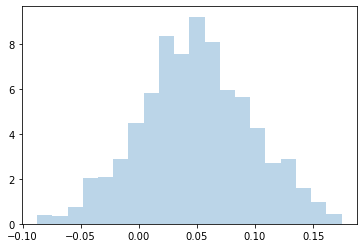

In [83]:
bins = 20#np.linspace(-np.pi/16*180/np.pi, np.pi/16*180/np.pi, 20)
#h1 = plt.hist(flat_samples_1*180/np.pi, bins=bins, density=True, alpha=.3)
#h2 = plt.hist(flat_samples_10*180/np.pi, bins=bins, density=True, alpha=.3)
#h3 = plt.hist(flat_samples_100*180/np.pi, bins=bins, density=True, alpha=.3)
h3 = plt.hist(flat_samples_1000*180/np.pi, bins=bins, density=True, alpha=.3)
#plt.ylim(0, 2)

0 2
-0.39269908169872414 1.38857127458320e-1190
-0.367363657073 1.58238905351419e-1190
-0.34202823244727587 1.79147163818127e-1190
-0.31669280782155174 2.01423286920817e-1190
-0.2913573831958276 2.24839126757960e-1190
-0.26602195857010347 2.49094850936761e-1190
-0.2406865339443793 2.73820400482118e-1190
-0.21535110931865517 2.98581810040406e-1190
-0.19001568469293104 3.22890852178648e-1190
-0.1646802600672069 3.46218803465537e-1190
-0.13934483544148274 3.68015160943596e-1190
-0.1140094108157586 3.87729788656188e-1190
-0.08867398619003447 4.04836897177543e-1190
-0.06333856156431034 4.18860468006876e-1190
-0.0380031369385862 4.29397228276141e-1190
-0.012667712312862067 4.36136227594604e-1190
0.012667712312862067 4.38875899946765e-1190
0.0380031369385862 4.37535365105514e-1190
0.06333856156431034 4.32158910462702e-1190
0.08867398619003447 4.22912030598316e-1190
0.11400941081575866 4.10073327210619e-1190
0.1393448354414828 3.94019490834151e-1190
0.16468026006720693 3.75205967029766e-1190
0

Text(0, 0.5, 'Likelihood')

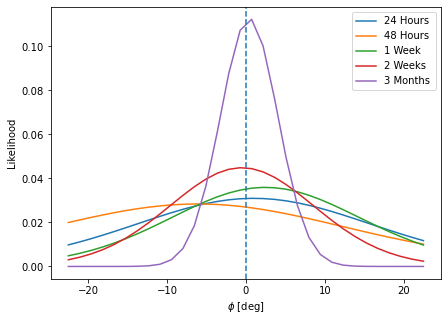

In [60]:
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from matplotlib.lines import Line2D
# sympy allows symbolic calculations, so an arbitrary float precision.
# That's the only way I found to deal with the crazy numbers in the 
# likelihood function before normalization. Im pretty sure there exists
# way more elegant methods. Feel free to make it cleaner !!
import sympy as sp

snr = cta.getSNRGrid()
mask = snr < 0

fig = plt.figure(constrained_layout=False, figsize=(7,5))
N_phi    = 32
phi_range = np.pi / 8
phis = np.linspace(-phi_range, phi_range, N_phi)
dphi = 2 * phi_range / N_phi

nights = [2,4,14,28,180]
to_plot = nights
labels = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks', '3 Months']
L = np.array([sp.zeros(N_phi, 1) for i in range(len(nights))])
idx = 0

for i, i_nights in enumerate(to_plot):
    signal = cta.getSignal(nNights = i_nights, phi_source = 0, bNoise=True)

    print(i, i_nights)
    for k, phi in enumerate(phis):
        model = cta.getSignal(nNights = i_nights, phi_source = phi, bNoise=False)
        
        mask = (snr * i_nights**0.5 > 1e-5 )
        std = model[mask] / (snr[mask] * i_nights**0.5)
        obs = signal[mask]
        exp = model[mask]
        chi2 =  (obs - exp)**2 / std**2
        p = sp.exp(-0.5*np.sum(chi2))
        L[i][k] = p
    norm = np.sum(L[i,:]) * dphi
    L[i,:] = L[i,:] / norm
    if i_nights in to_plot:
        print(i, idx, labels[idx])
        plot = plt.plot((phis) * 180 / np.pi, L[i,:] * np.pi / 180, label=labels[idx])
        """
        upper_ax[idx].pcolormesh(xx ,yy ,signal, norm=LogNorm())#, vmin=2.7e-4, vmax=3.2e-4)
        upper_ax[idx].set_yticklabels([])
        upper_ax[idx].set_xticklabels([])
        upper_ax[idx].xaxis.set_ticks_position('none') 
        upper_ax[idx].yaxis.set_ticks_position('none') 
        line = [Line2D([0], [0], color=plot[0].get_color())]
        upper_ax[idx].legend(line, ['{} nights'.format(int(i_nights))],
                             loc='lower center', bbox_to_anchor=(0.5, -0.35))
        """
        idx = idx + 1
        
plt.legend()
        
plt.axvline(x=0, linestyle="--")
#ax5.set_xlim(-10, 10)
plt.xlabel('$\phi$ [deg]')
plt.ylabel('Likelihood')

#plt.savefig('likelihood_phi.pdf')

40.7436654315252
40.7436654315252
40.7436654315252
40.7436654315252
40.7436654315252


Text(0, 0.5, 'Likelihood')

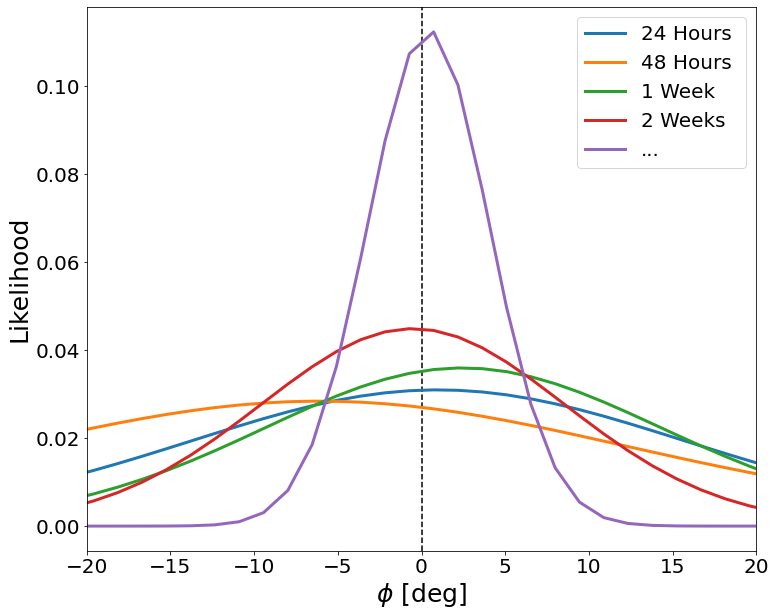

In [88]:
fig = plt.figure(figsize=(12,10))
idx = 0
plt.axvline(x=0, linestyle="--", c='k')
labels = ['24 Hours', '48 Hours ', '1 Week', '2 Weeks', '...']
to_plot = nights
for i, i_nights in enumerate(to_plot):
    if i_nights in to_plot:
        x = (phis) * 180 / np.pi
        y = L[i,:] * np.pi / 180
        #y[np.fabs(x)>5]=0
        halfmax = np.max(y) / 2
        where = y > halfmax
        plot = plt.plot(x, y, label=labels[idx], lw=3)
        idx = idx + 1
    
    print(np.sum(L[i,:]))
    #np.savetxt("ELT_VLT_{}nights.txt".format(i_nights), np.c_[x, y], delimiter='\t')
plt.legend(fontsize=20)
plt.xlim(-20, 20)
#plt.ylim(0, 4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('$\phi$ [deg]',fontsize=25)
plt.ylabel('Likelihood',fontsize=25)
#plt.savefig('likelihood_plot_ELT_VLT.pdf', bbox_inches='tight')